# Training and evaluation notebook for wideResNet based Brevis Model.
<HR>
Models are trained on the CIFAR10 dataset, and uses CIFAR100 as an OOD dataset. <br>
    2 models are trained, one with branches using BrevisEnergy Loss and one using Cross entropy for all exits. <br>
    
    


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os
from keras_flops import get_flops 
from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

### load datasets

<hr>

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


## Initialize functions for building the loss functions 
<hr>

In [4]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


In [5]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl

def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)

def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost

In [6]:
from scipy.special import logsumexp

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(p,alpha)
        return (A + B) + C
    return custom_loss_function


def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        evidence = tf.exp(logits)
        # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    return  brevisEnergy


## Build the Model
<hr>

In [7]:
# ### from scratch model

import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
# model.save('./models/cifaroutlier_EDL_adam.hdf5')
# loss = kl_loss(lambda_callback)
# loss = brevisEnergy(lambda_callback)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# _base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
#      weights='imagenet',include_top=False)

# x = _base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

# base_model = tf.keras.models.Model(inputs=_base_model.input, outputs=x)
# base_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#               loss=loss,
#               metrics=['accuracy'])
# history = base_model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])


base_model = keras.models.load_model("./models/wideresnet_.81.hdf5")
base_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              # tf.keras.optimizers.Adam(),
              # tf.optimizers.SGD(lr=0.001, momentum=0.9)
              loss=loss,
              metrics=['accuracy'])

base_model.evaluate(test_ds)


313/313 [==============================] - 19s 45ms/step - loss: 1.0274 - accuracy: 0.8118


[1.0274261236190796, 0.8118000030517578]

In [8]:
base_model.summary()
# Calculae FLOPS
print(base_model.outputs)
flops = get_flops(base_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 32, 32, 16)   432         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_75 (BatchN  (None, 32, 32, 16)  64          ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_75 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_75[0]

## Branch the model
First we will train the BrevisNet version of the model with BrevisEnergy loss
<hr>

In [35]:
lambda_callback = lambda_update(100,0,max_t = 0.01)
branch_loss = brevisEnergy(lambda_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


# model = brevis.BranchModel(name="./models/wideresnet_.81.hdf5", custom_objects={})
# # model.add_branches([_branch_flat,_branch_flat],
# #                           ["conv2_block1_out","conv2_block3_out",
# #                             # "dense"
# #                           ],
# #                           target_input=False,loop=False,num_outputs=10)

# # model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
# model.compile(loss=branch_loss, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#                   # optimizer="adam",
#               preset="", metrics=['accuracy'])
x = base_model.layers[-2].output
print(x)
x = tf.keras.layers.Dense(10,name="classification")(x) #remove the softmax

model = keras.models.Model(inputs =base_model.input, outputs = x) 

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              # tf.keras.optimizers.Adam(),
              # tf.optimizers.SGD(lr=0.001, momentum=0.9)
              loss=branch_loss,
              metrics=['accuracy'])

KerasTensor(type_spec=TensorSpec(shape=(None, 40960), dtype=tf.float32, name=None), name='flatten_3/Reshape:0', description="created by layer 'flatten_3'")


In [36]:
# model = brevis.BranchModel(name="./models/resnet50_finetuned_32.hdf5", custom_objects={})
# model.compile(loss=[trunk_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])
# model.evaluate(test_ds)

In [37]:
model.fit(train_ds, epochs = 10, validation_data=validation_ds, callbacks=[lambda_callback])

annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 225s 158ms/step - loss: 0.8304 - accuracy: 0.6671 - val_loss: 0.5346 - val_accuracy: 0.8874
annealing coef updated to: 0.01
Epoch 2/10
1407/1407 [==============================] - 223s 158ms/step - loss: 0.6361 - accuracy: 0.9013 - val_loss: 0.5863 - val_accuracy: 0.9152
annealing coef updated to: 0.01
Epoch 3/10
1407/1407 [==============================] - 223s 158ms/step - loss: 0.5569 - accuracy: 0.9248 - val_loss: 0.5350 - val_accuracy: 0.9274
annealing coef updated to: 0.01
Epoch 4/10
  56/1407 [>.............................] - ETA: 3:27 - loss: 0.5323 - accuracy: 0.9291

KeyboardInterrupt: 

In [38]:
model.evaluate(test_ds)

313/313 [==============================] - 14s 45ms/step - loss: 0.6241 - accuracy: 0.8577


[0.6240578293800354, 0.857699990272522]

In [45]:
model.save("./models/journal_models/wideresnet_Brev_conv3_5.hdf5")

In [7]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# model = tf.keras.models.load_model("./models/journal_models/inception_Brev_conv3_10.h5",custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy(lambda_callback)})


preset: Other


## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [39]:
output_ID_Brev= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 1


In [16]:
from scipy.io import loadmat
# Model / data parameters
train_raw = loadmat('./data/svhn/train_32x32.mat')
test_raw = loadmat('./data/svhn/test_32x32.mat')
# Load images and labels
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

# Model / data parameters
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
# (x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(train_labels, num_classes)
# y_test = keras.utils.to_categorical(test_labels, num_classes)
def augment_images(image, label):
    return tf.image.resize(image,(227,227)), label

train_ds_svhn = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# train_ds_svhn = (train_ds_svhn.map(augment_images))

test_ds_svhn = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# test_ds_svhn = (test_ds_svhn.map(augment_images))

train_ds_svhn = (train_ds_svhn                
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds_svhn = (test_ds_svhn
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds_svhn)
print(test_ds_svhn)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


In [40]:
output_OOD_Brev = evaluate.getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 1


In [ ]:
# output_OOD_svhn = getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
# output_OOD_svhn['correct']=0
# output_OOD_svhn['outlier']=1


In [49]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'wideresnet_Brev_conv3_5'
save_outputs(filename+'_ID',output_ID)
save_outputs(filename+'_OOD',output_OOD)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

### T/F in distribution performance
<hr>

metric:  energy threshold:  mean
['exit_1', 'exit_2']
2229 inputs accepted 2106 Correct


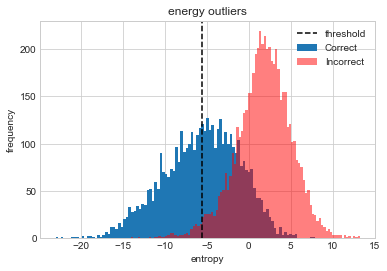

-----------------
rollover enabled, 7771 predictions provided
['exit_1', 'exit_2']
2169 inputs accepted 2108 Correct


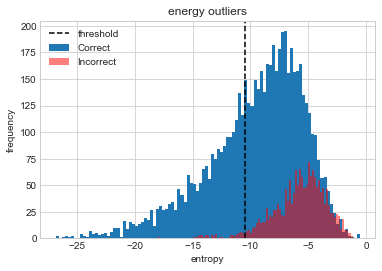

-----------------
rollover enabled, 5602 predictions provided
main_exit
5602 inputs accepted 4386 Correct


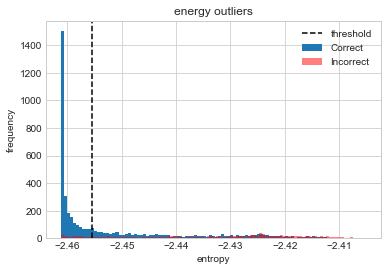

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.4419           0.441900  -5.571860      2229              2106        0.222900             0.944818
1     exit_2         7771         0.8145           0.775833 -10.467496      2169              2108        0.279115             0.971876
2  Main_exit         5602         0.8648           0.782935  -2.455447      5602              4386        1.000000             0.782935


In [51]:
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=True)


In [52]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)


metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.4419           0.441900   0.168403      5582              3999         0.55820              0.71641
1     exit_2         4418         0.8145           0.800362 -13.578604       750               744         0.16976              0.99200
2  Main_exit         3668         0.8648           0.818430  -2.405365      3668              3002         1.00000              0.81843


In [53]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.4419           0.441900   0.168403      5582              3999         0.55820              0.71641
1     exit_2         4418         0.8145           0.800362 -13.578604       750               744         0.16976              0.99200
2  Main_exit         3668         0.8648           0.818430  -2.405365      3668              3002         1.00000              0.81843
metric:  energy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.4419           0.441900  -5.571860      2229              2106        0.222900             0.944818
1     exit_2         7771       

### ID/OOD branch performance
<hr>

metric:  energy threshold:  gmean
energy  lr_auc 0.1966841897109816 Best Threshold=-6.124537944793701, G-Mean=0.7365389840248591, TPR=0.791988756148981, FPR=0.31502856476623525


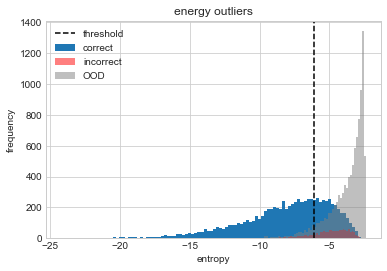

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10048         0.8577  -6.124538         6172           679              5875            0.90089             0.857539
metric:  entropy threshold:  gmean
entropy  lr_auc 0.13774291030343044 Best Threshold=0.77903151512146, G-Mean=0.7935631709001493, TPR=0.8629655657062544, FPR=0.2702576658505305


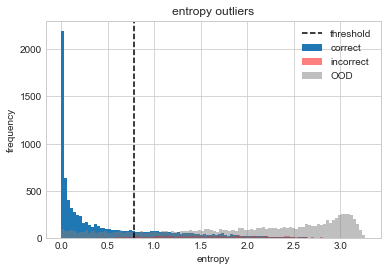

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10048         0.8577   0.779032         6455          1668              6259           0.794657             0.770528
metric:  uncert threshold:  gmean
uncert  lr_auc 0.19918540416520314 Best Threshold=0.021416321396827698, G-Mean=0.7365389840248591, TPR=0.791988756148981, FPR=0.31502856476623525


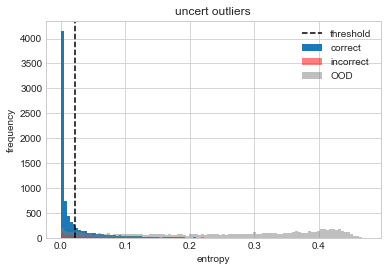

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10048         0.8577   0.021416         6172           679              5875            0.90089             0.857539


In [43]:
evaluate.buildCompareDistribPlot(output_ID_Brev, output_OOD_Brev, ["energy"], "gmean",plot=True,main_exit_included=False)
evaluate.buildCompareDistribPlot(output_ID_Brev, output_OOD_Brev, ["entropy"], "gmean",plot=True,main_exit_included=False)
evaluate.buildCompareDistribPlot(output_ID_Brev, output_OOD_Brev, ["uncert"], "gmean",plot=True,main_exit_included=False)

metric:  calibration threshold:  gmean
calibration  lr_auc 0.8473543069166563 Best Threshold=0.22421382367610931, G-Mean=0.7729161477751264, TPR=0.7111357477211135, FPR=0.15993623804463336


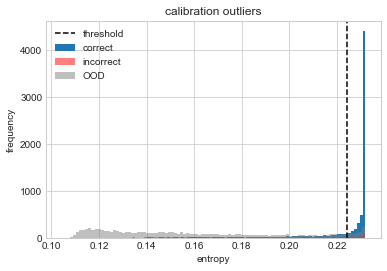

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10048         0.8118   0.224214         6074           753              5773           0.889703             0.845613
metric:  energy threshold:  gmean
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698


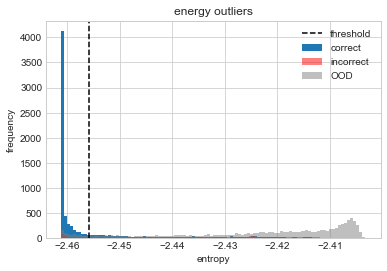

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10048         0.8118  -2.455758         6046           728              5750            0.89253             0.848834


In [24]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",plot=True,main_exit_included=False)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True,main_exit_included=False)
# evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=False)


# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

In [ ]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6186  -23.82761         3815          1707              3233           0.690873             0.585476
1     exit_2       6185        8293         0.6842 -28.898783         1039           464               946           0.691284             0.629408
2  Main_exit       5146        7829         0.7229         NA         5146          7829              2975           0.396609             0.229287


In [75]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


metric:  energy threshold:  mean
OOD size 0.1


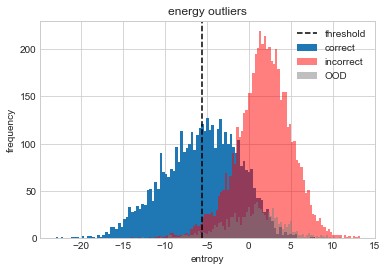

['exit_1', 'exit_2']


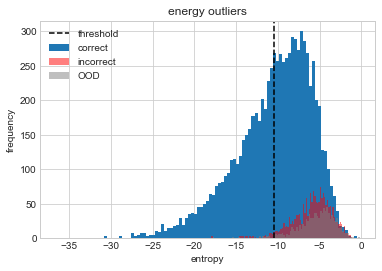

['exit_1', 'exit_2']


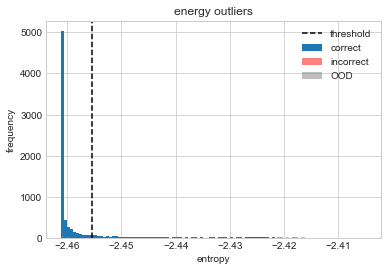

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.4419   -5.57186         2229            60              2106           0.973788             0.920052
1     exit_2       7771         940         0.8145 -10.467496         2169            24              2108           0.989056             0.961240
2  Main_exit       5602         916         0.8648         NA         5602           916              4386           0.859466             0.672906
OOD size 0.2


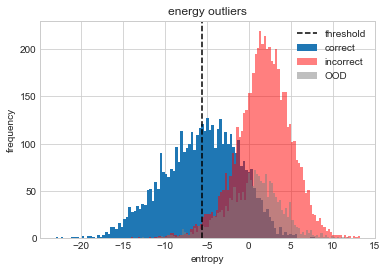

['exit_1', 'exit_2']


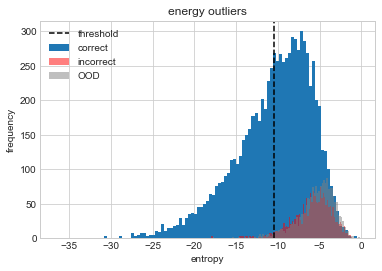

['exit_1', 'exit_2']


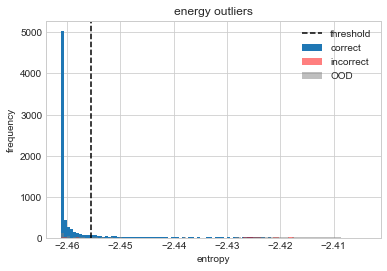

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.4419   -5.57186         2229           101              2106           0.956652             0.903863
1     exit_2       7771        1899         0.8145 -10.467496         2169            57              2108           0.974394             0.946990
2  Main_exit       5602        1842         0.8648         NA         5602          1842              4386           0.752552             0.589199
OOD size 0.5


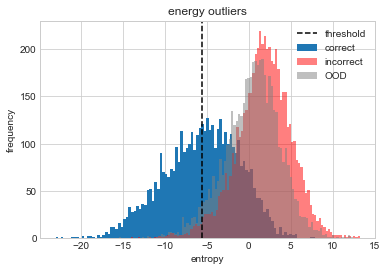

['exit_1', 'exit_2']


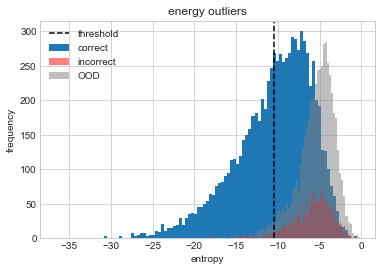

['exit_1', 'exit_2']


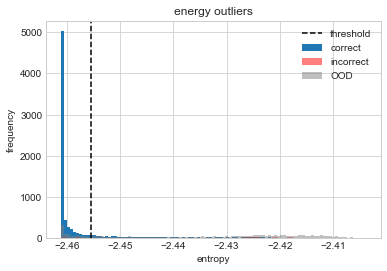

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        5000         0.4419   -5.57186         2229           232              2106           0.905729             0.855750
1     exit_2       7771        4768         0.8145 -10.467496         2169           141              2108           0.938961             0.912554
2  Main_exit       5602        4627         0.8648         NA         5602          4627              4386           0.547659             0.428781
OOD size 1


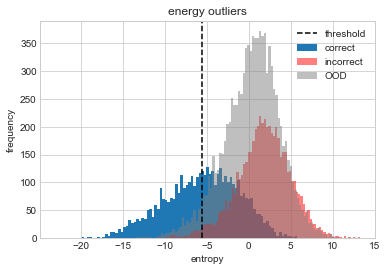

['exit_1', 'exit_2']


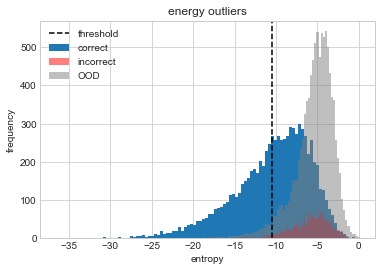

['exit_1', 'exit_2']


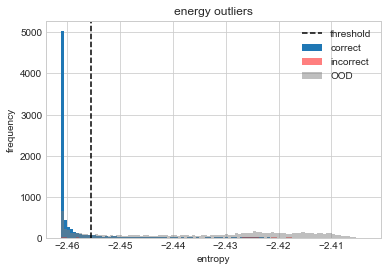

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.4419   -5.57186         2229           466              2106           0.827087             0.781447
1     exit_2       7771        9534         0.8145 -10.467496         2169           293              2108           0.880991             0.856214
2  Main_exit       5602        9241         0.8648         NA         5602          9241              4386           0.377417             0.295493


In [77]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "mean",OOD_rate=[.1,.2,.5,1],plot=True)


## Entropy Branch version
Now we build a branched model with the entropy metric and cross entropy loss for comparision.
<hr>

In [55]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./models/wideresnet_.81.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])

model.summary()


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000016FCBBD7388>

preset: Other
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                               

In [56]:
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=True,callbacks=[lambda_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 278s 195ms/step - loss: 2.4611 - dense_3_loss: 0.1722 - branch_exit_loss: 1.1862 - branch_exit_1_loss: 0.7447 - dense_3_accuracy: 0.9417 - branch_exit_accuracy: 0.6133 - branch_exit_1_accuracy: 0.7422 - val_loss: 1.9256 - val_dense_3_loss: 0.1696 - val_branch_exit_loss: 0.8319 - val_branch_exit_1_loss: 0.5699 - val_dense_3_accuracy: 0.9412 - val_branch_exit_accuracy: 0.7062 - val_branch_exit_1_accuracy: 0.8080
annealing coef updated to: 0.001
Epoch 2/5
1407/1407 [==============================] - 276s 196ms/step - loss: 1.6505 - dense_3_loss: 0.1219 - branch_exit_loss: 0.7380 - branch_exit_1_loss: 0.4402 - dense_3_accuracy: 0.9618 - branch_exit_accuracy: 0.7438 - branch_exit_1_accuracy: 0.8479 - val_loss: 1.7529 - val_dense_3_loss: 0.1534 - val_branch_exit_loss: 0.7498 - val_branch_exit_1_loss: 0.5030 - val_dense_3_accuracy: 0.9468 - val_br

In [57]:
model.evaluate(test_ds)

313/313 [==============================] - 19s 59ms/step - loss: 1.9134 - dense_3_loss: 0.4517 - branch_exit_loss: 0.6131 - branch_exit_1_loss: 0.5233 - dense_3_accuracy: 0.8630 - branch_exit_accuracy: 0.7911 - branch_exit_1_accuracy: 0.8391


[1.9133697748184204,
 0.45171138644218445,
 0.6130933165550232,
 0.5233008861541748,
 0.8629999756813049,
 0.791100025177002,
 0.8391000032424927]

In [58]:
model.save("./models/journal_models/wideresnet_B_conv3_5.hdf5")

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [59]:
output_ID_old= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID_old:
    i['outlier']=0


outputs 3


In [60]:
output_OOD_old = evaluate.getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD_old:
    i['correct']=0
    i['outlier']=1

outputs 3


In [63]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'wideresnet_B_conv3_5'
save_outputs(filename+'_ID',output_ID_old)
save_outputs(filename+'_OOD',output_OOD_old)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

### T/F in distribution performance
<hr>

metric:  energy threshold:  mean
['exit_1', 'exit_2']
3766 inputs accepted 3546 Correct


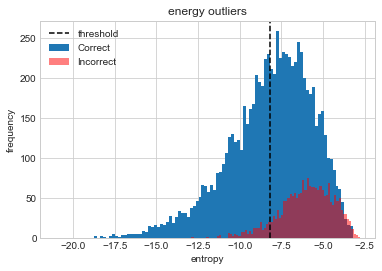

-----------------
rollover enabled, 6234 predictions provided
['exit_1', 'exit_2']
890 inputs accepted 856 Correct


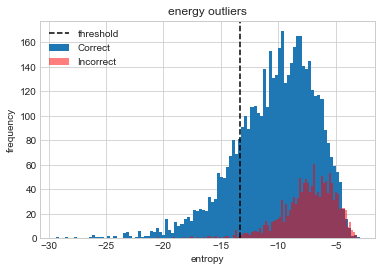

-----------------
rollover enabled, 5344 predictions provided
main_exit
5344 inputs accepted 4133 Correct


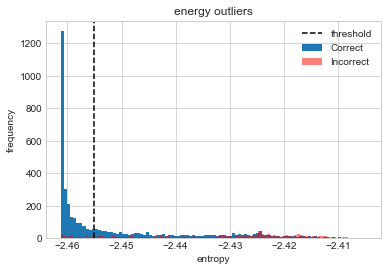

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100  -8.180323      3766              3546        0.376600             0.941583
1     exit_2         6234         0.8391           0.769811 -13.332321       890               856        0.142765             0.961798
2  Main_exit         5344         0.8630           0.773391  -2.455151      5344              4133        1.000000             0.773391


In [64]:
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["energy"],main_exit_included=True,plot=True)


In [67]:
evaluate.calculateBranching(output_ID_old,threshold="PR_AUC",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=False)


metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.082291      2090              2074        0.209000             0.992344
1     exit_2         7910         0.8391           0.798609   0.000280       467               467        0.059039             1.000000
2  Main_exit         7443         0.8630           0.817815   3.216030      7443              6087        1.000000             0.817815
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.575167      5029              4821        0.502900             0.958640
1     exit_2         4971     

### ID/OOD branch performance
<hr>

In [66]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "gmean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.082291         2090           198              2074           0.913462             0.906469
1     exit_2       7910        9802         0.8391   0.00028          467            31               467           0.937751             0.937751
2  Main_exit       7443        9771         0.8630        NA         7443          9771              6087           0.432381             0.353608
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.575167         5029          1397              4821           

In [ ]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["entropy"], "mean",OOD_rate=[.1,.2,.5,1],plot=False)


### Calibration 
<hr>

In [ ]:
evaluate.calculateBranching(output_ID_old,threshold="PR_AUC",metrics=["calibration"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["calibration"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["calibration"],main_exit_included=True,plot=False)


metric:  calibration threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.614095      7911              6945        0.791100             0.877892
1     exit_2         2089         0.8391           0.626137   0.763845      1256               951        0.601245             0.757166
2  Main_exit          833         0.8630           0.579832   0.181627       833               483        1.000000             0.579832
metric:  calibration threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.866677      5553              5265        0.555300             0.948136
1     exit_2         4

In [69]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "gmean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  calibration threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.614095         7911          5239              6945           0.601597             0.528137
1     exit_2       2089        4761         0.8391  0.763845         1256          1994               951           0.386462             0.292615
2  Main_exit        833        2767         0.8630        NA          833          2767               483           0.231389             0.134167
metric:  calibration threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.866677         5553          1932              5265   

In [74]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["calibration"], "mean",OOD_rate=[.1,.2,.5,1],plot=True)


NameError: name 'calc_auc_OOD' is not defined